In [16]:
import sys
sys.version

'3.7.6 (default, Jan  8 2020, 13:42:34) \n[Clang 4.0.1 (tags/RELEASE_401/final)]'

In [17]:
import pandas as pd
pd.__version__

'0.24.2'

In [18]:
import sklearn
sklearn.__version__

'0.23.2'

In [19]:
import time
import itertools
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
import numpy as np
from numpy import sort
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm

In [20]:
# dataset path
dataset_path = './csv/diff_dataset.csv'
testset_path = './csv/diff_testset.csv'

In [21]:
# read dataset
dataset = pd.read_csv(dataset_path, index_col=None, header=0)
testset = pd.read_csv(testset_path, index_col=None, header=0)

In [22]:
# drop unnamed column
dataset.drop(columns=['Unnamed: 0'], inplace=True)
testset.drop(columns=['Unnamed: 0'], inplace=True)

In [23]:
# Delete the following states
# 0: ixnetwork-traffic-start
# 2: node-up
# 4: interface-up
# 6: tap-loss-stop
# 8: tap-delay-stop
# 10: ixnetwork-bgp-injection-stop
# 12: ixnetwork-bgp-hijacking-stop
data_drop_index = dataset[dataset['v_type_code'] % 2 == 0].index.tolist()
dataset.drop(index=data_drop_index, axis=0, inplace=True)
test_drop_index = testset[testset['v_type_code'] % 2 == 0].index.tolist()
testset.drop(index=test_drop_index, axis=0, inplace=True)

# Try to combine 5 and 7 into one type.
dataset['v_type_code'] = dataset['v_type_code'].apply(lambda x: 57 if x == 5 or x == 7 else x)
testset['v_type_code'] = testset['v_type_code'].apply(lambda x: 57 if x == 5 or x == 7 else x)

print('dataset:')
print(dataset.shape)
print('testset:')
print(testset.shape)

dataset:
(930, 997)
testset:
(840, 997)


In [24]:
# train test split
column = dataset.columns
X_train = dataset[column[:-1]]
X_test = testset[column[:-1]]
y_train = dataset[column[-1]]
y_test = testset[column[-1]]

X = pd.concat([X_train, X_test], axis=0, ignore_index=True, sort=False)
Y = pd.concat([y_train, y_test], axis=0, ignore_index=True, sort=False)

#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print(X.shape, Y.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1770, 996) (1770,)
(930, 996) (930,)
(840, 996) (840,)


In [25]:
ss = StandardScaler()
std_X_train = ss.fit_transform(X_train)
std_X_test = ss.fit_transform(X_test)

# Random Forest

In [35]:
def random_forest(X_train, y_train, X_test, y_test, show=False, estimators=100):
    last_time = time.time()
    rf = RandomForestClassifier(n_estimators=estimators, max_depth=None, min_samples_split=2, random_state=0)

    rf.fit(X_train, y_train)
    middle_time = time.time()

    y_pred = rf.predict(X_test)

    current_time = time.time()
    print("n_estimators: %d" % estimators)
    print("RF Accuracy: %.2f" % accuracy_score(y_test, y_pred))
    print("train time： {}".format(middle_time - last_time))
    print("test time： {}".format(current_time - middle_time))
    if show:
        cm = confusion_matrix(y_test, y_pred)
        print('confusion matrix rf:')
        print(cm)
        print('classification report rf:')
        print(classification_report(y_test, y_pred))
    
    return rf

In [36]:
rf = random_forest(X_train, y_train, X_test, y_test, show=True)

n_estimators: 100
RF Accuracy: 0.92
train time： 0.8418822288513184
test time： 0.02376866340637207
confusion matrix rf:
[[ 64   0   0   0   0]
 [  0  72   0   0   0]
 [  0   0 156   0   0]
 [  0   0   0 131  49]
 [  0   1   0  19 348]]
classification report rf:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        64
           3       0.99      1.00      0.99        72
           9       1.00      1.00      1.00       156
          11       0.87      0.73      0.79       180
          57       0.88      0.95      0.91       368

    accuracy                           0.92       840
   macro avg       0.95      0.93      0.94       840
weighted avg       0.92      0.92      0.92       840



In [87]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
indices = indices[:30]
# Print the feature ranking
print("Feature ranking:")
print(indices)
feature_columns = column[indices]
print(feature_columns)
print(importances[indices])

Feature ranking:
[357 355 330 346 347 345 361 343 344 407 408 314 348 331 812 360 967 731
 252 349 412 755 906 350 852 703 743 680 437 356]
Index(['n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/total-memory',
       'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/activities/prefixes',
       'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/current-prefixes',
       'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/prefixes/memory-usage',
       'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/path/total-entries',
       'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/prefixes/total-entries',
       'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-neighbor-summaries/bgp-neighbor-summary/table-vers

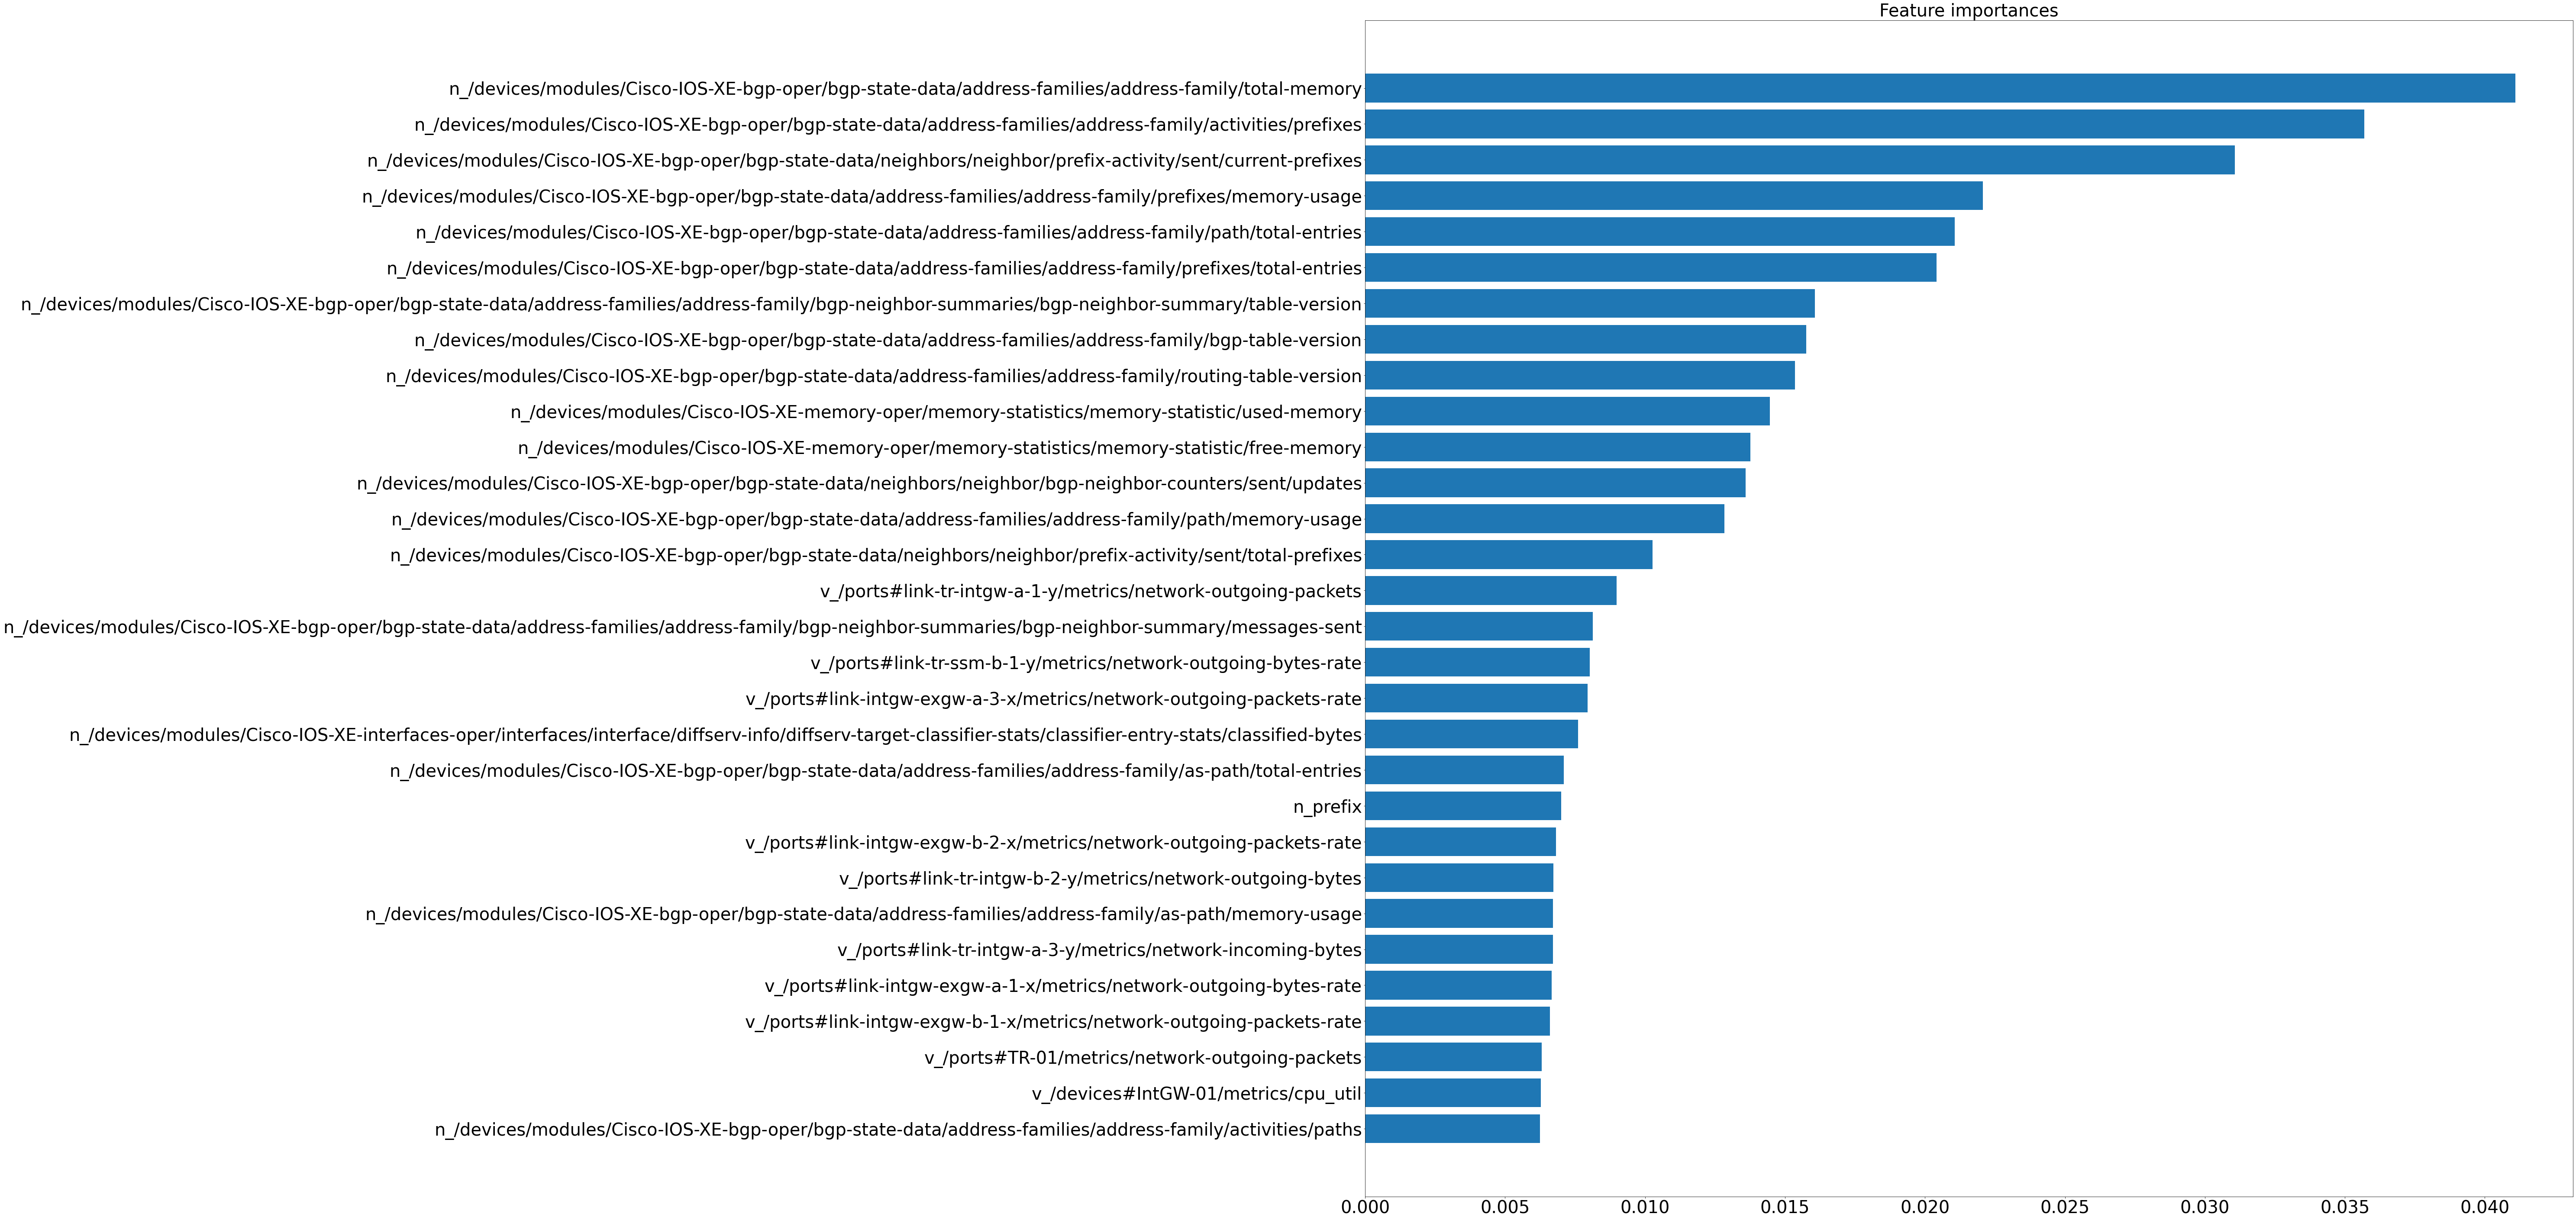

In [86]:
plt.subplots(figsize=(50, 50))
plt.title("Feature importances", fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.barh(feature_columns[::-1], importances[indices][::-1])
plt.show()

In [26]:
# XGBoost
def xgboost(X_train, y_train, X_test, y_test, show=False, plt_show=True):
    last_time = time.time()
    xgb = XGBClassifier(n_estimators=100, objective='multi:softprob', num_class=5, random_state=0)
    xgb.fit(X_train, y_train)
    middle_time = time.time()
    y_pred = xgb.predict(X_test)
    current_time = time.time()
    accuracy_score(y_test, y_pred)

#     print("train time： {}".format(middle_time - last_time))
#     print("test time： {}".format(current_time - middle_time))
    if show:
        cm = confusion_matrix(y_test, y_pred)
        report=classification_report(y_test, y_pred, output_dict=True)
        report['train_time']=middle_time - last_time
        report['test_time']=current_time - middle_time
        return report

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red")
        # color="red" if cm[i, j] > thresh else "black")
    # plt.set_tight_layout(True)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [28]:
model = XGBClassifier(importance_type='gain',n_estimators=100)
model.fit(X, Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

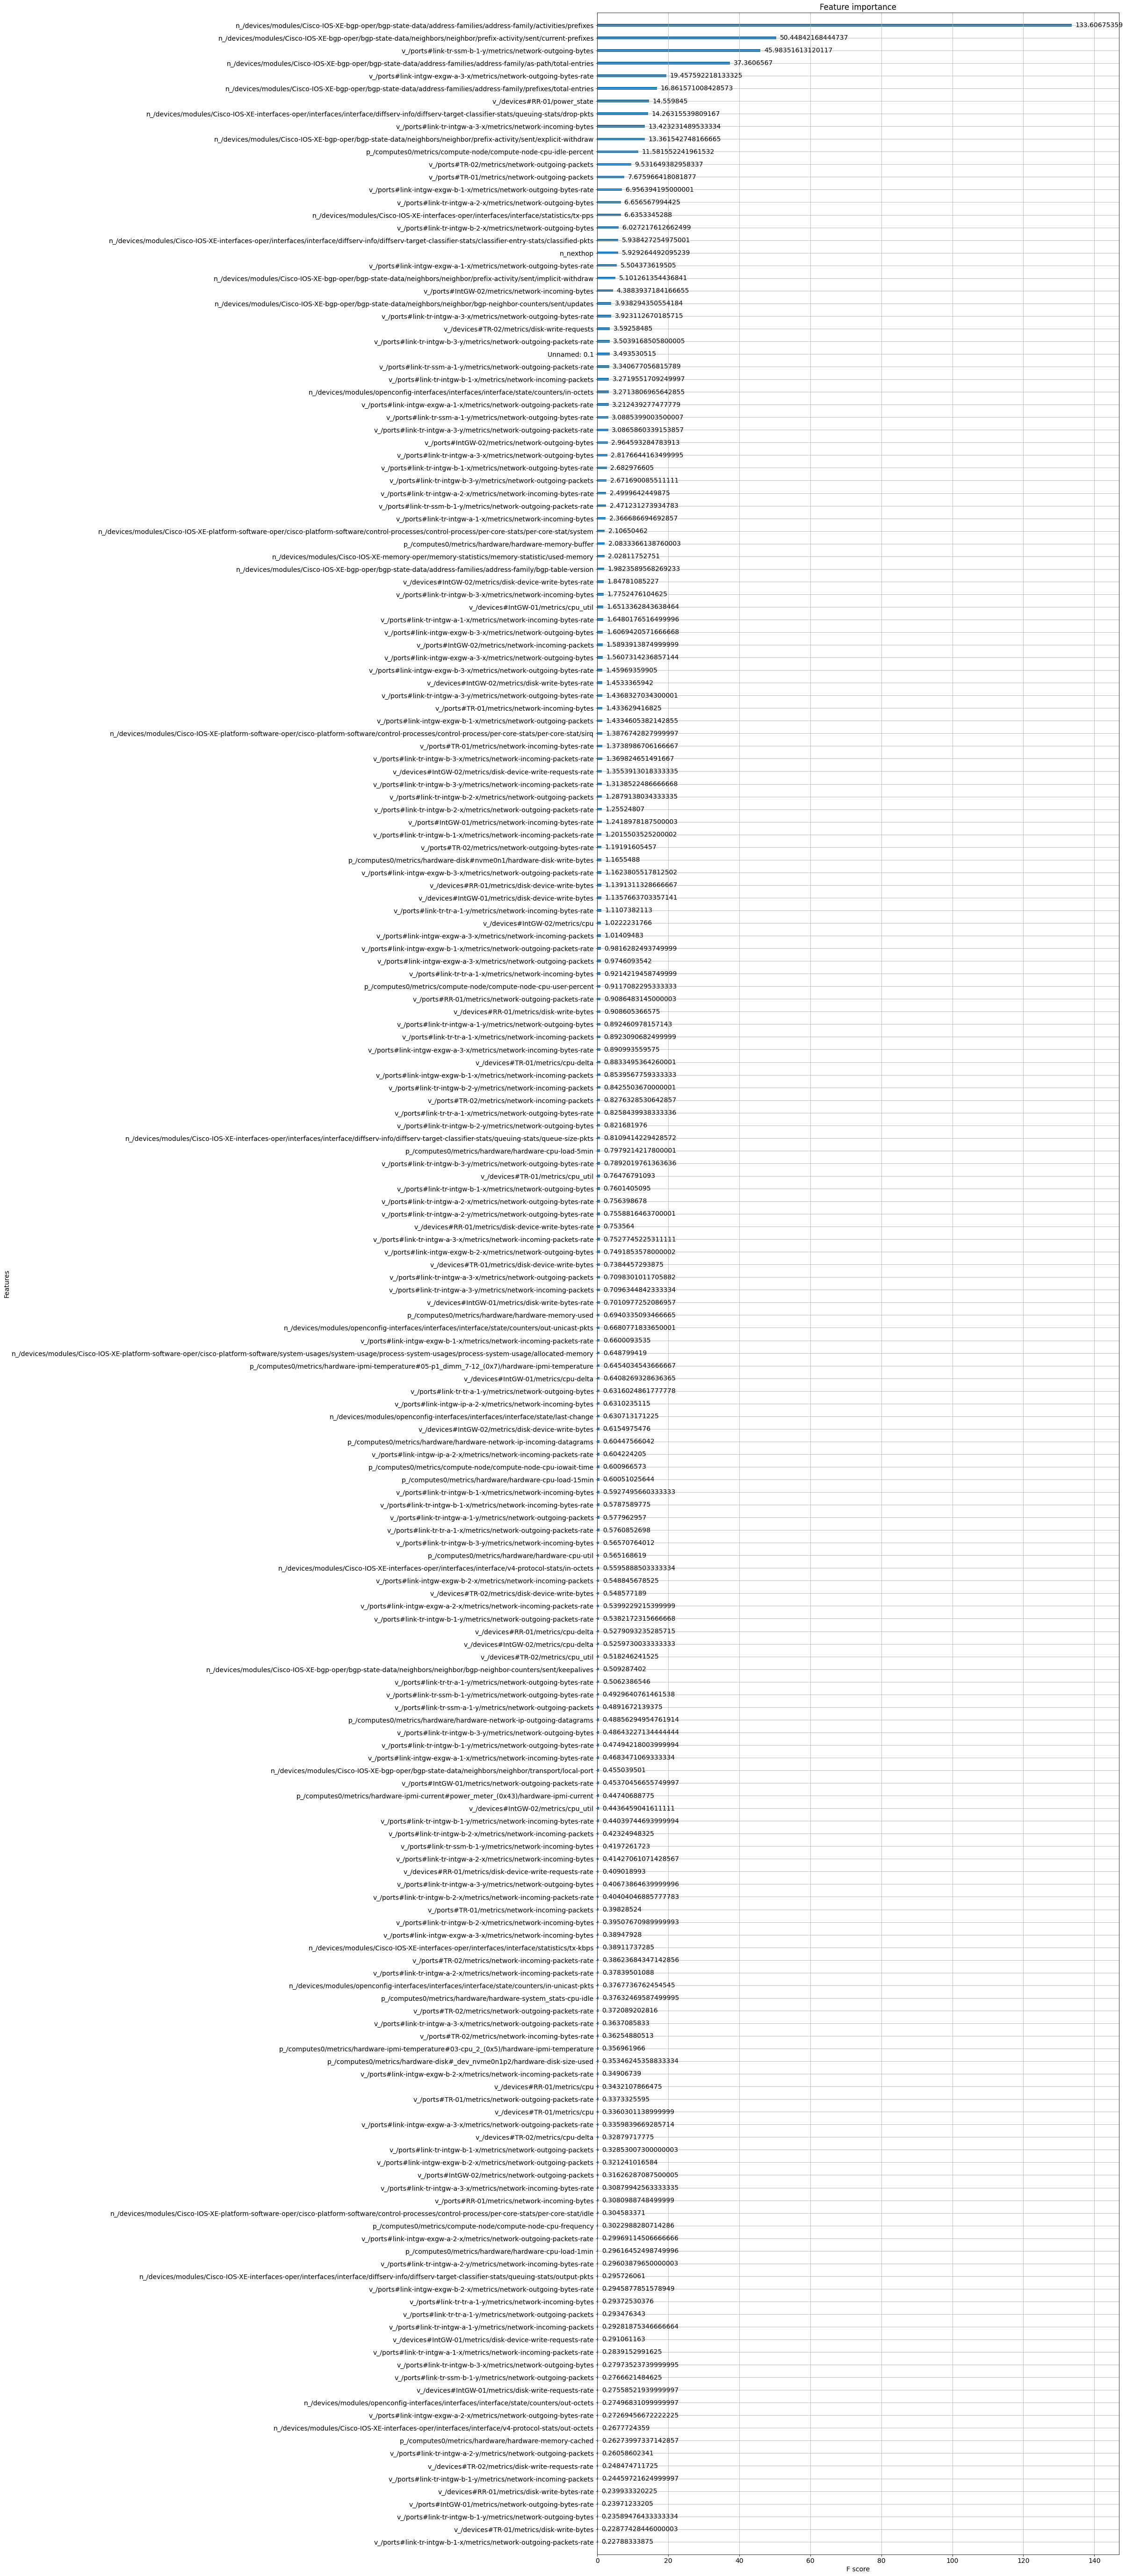

In [29]:
_, ax = plt.subplots(figsize=(20, 100))
plt.rc('font', size=14)
plt.rc('axes', labelsize=14) 
plot_importance(model, ax=ax, max_num_features=200, importance_type='gain')
plt.show()

In [30]:
im=pd.DataFrame({'importance':model.feature_importances_,'var':X.columns})
im=im.sort_values(by='importance',ascending=False)
im.to_csv("feature_important_data_XG_2021.csv")

In [31]:
thresholds = sort(model.feature_importances_)[-200:]
print(thresholds)

[0.00036575 0.00036718 0.0003786  0.00038473 0.00038509 0.00039257
 0.00039879 0.00041823 0.00042169 0.00042977 0.00043767 0.00044131
 0.00044231 0.00044403 0.00044897 0.00045567 0.00046714 0.00046996
 0.00047102 0.00047142 0.0004728  0.00047463 0.00047513 0.00047533
 0.00048099 0.00048518 0.00048885 0.00049449 0.00049561 0.00050759
 0.00051558 0.00052728 0.00052771 0.00053924 0.00053932 0.00054141
 0.00055084 0.00056024 0.0005673  0.00057291 0.00058188 0.00058374
 0.00059719 0.00060399 0.00060471 0.00060731 0.0006199  0.00062452
 0.0006251  0.00063409 0.00063923 0.00064847 0.0006528  0.00065646
 0.00066489 0.00067365 0.0006793  0.00070682 0.00071204 0.00071807
 0.00072818 0.00073032 0.00075168 0.00076227 0.00078071 0.00078413
 0.0007851  0.00079119 0.0008125  0.00081739 0.00083177 0.00084417
 0.00084728 0.00086382 0.00086656 0.00088045 0.00088088 0.00089812
 0.00090708 0.00090794 0.0009246  0.00092761 0.00092889 0.00095134
 0.0009638  0.00096453 0.00096976 0.00097016 0.00098785 0.0010

In [37]:
list_1=[]
list_3=[]
list_5_7=[]
list_9=[]
list_11=[]

list_1_rc=[]
list_3_rc=[]
list_5_7_rc=[]
list_9_rc=[]
list_11_rc=[]

list_acc=[]
list_train_time=[]
list_test_time=[]

for thresh in thresholds:
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    select_X_test = selection.transform(X_test)
    # 格式：'1': {'precision': 0.9824561403508771, 'recall': 0.875, 'f1-score': 0.9256198347107438, 'support': 64}
    report = xgboost(select_X_train, y_train, select_X_test, y_test,show=True)
    list_1.append(report['1']['precision'])
    list_3.append(report['3']['precision'])
    list_5_7.append(report['57']['precision'])
    list_9.append(report['9']['precision'])
    list_11.append(report['11']['precision'])
    
    list_1_rc.append(report['1']['recall'])
    list_3_rc.append(report['3']['recall'])
    list_5_7_rc.append(report['57']['recall'])
    list_9_rc.append(report['9']['recall'])
    list_11_rc.append(report['11']['recall'])
    
    list_train_time.append(report['train_time'])
    list_test_time.append(report['test_time'])
    list_acc.append(report['accuracy'])
    print("Thresh=%.4f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], report['accuracy'] * 100.0))

Thresh=0.0004, n=200, Accuracy: 93.93%
Thresh=0.0004, n=199, Accuracy: 93.93%
Thresh=0.0004, n=198, Accuracy: 93.93%
Thresh=0.0004, n=197, Accuracy: 93.81%
Thresh=0.0004, n=196, Accuracy: 94.05%
Thresh=0.0004, n=195, Accuracy: 93.93%
Thresh=0.0004, n=194, Accuracy: 93.81%
Thresh=0.0004, n=193, Accuracy: 93.93%
Thresh=0.0004, n=192, Accuracy: 94.05%
Thresh=0.0004, n=191, Accuracy: 93.81%
Thresh=0.0004, n=190, Accuracy: 93.69%
Thresh=0.0004, n=189, Accuracy: 93.93%
Thresh=0.0004, n=188, Accuracy: 93.93%
Thresh=0.0004, n=187, Accuracy: 93.81%
Thresh=0.0004, n=186, Accuracy: 93.93%
Thresh=0.0005, n=185, Accuracy: 93.69%
Thresh=0.0005, n=184, Accuracy: 93.81%
Thresh=0.0005, n=183, Accuracy: 93.81%
Thresh=0.0005, n=182, Accuracy: 93.69%
Thresh=0.0005, n=181, Accuracy: 93.81%
Thresh=0.0005, n=180, Accuracy: 93.93%
Thresh=0.0005, n=179, Accuracy: 93.81%
Thresh=0.0005, n=178, Accuracy: 93.81%
Thresh=0.0005, n=177, Accuracy: 93.81%
Thresh=0.0005, n=176, Accuracy: 93.81%
Thresh=0.0005, n=175, Acc

/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
print(len(list_1))

200


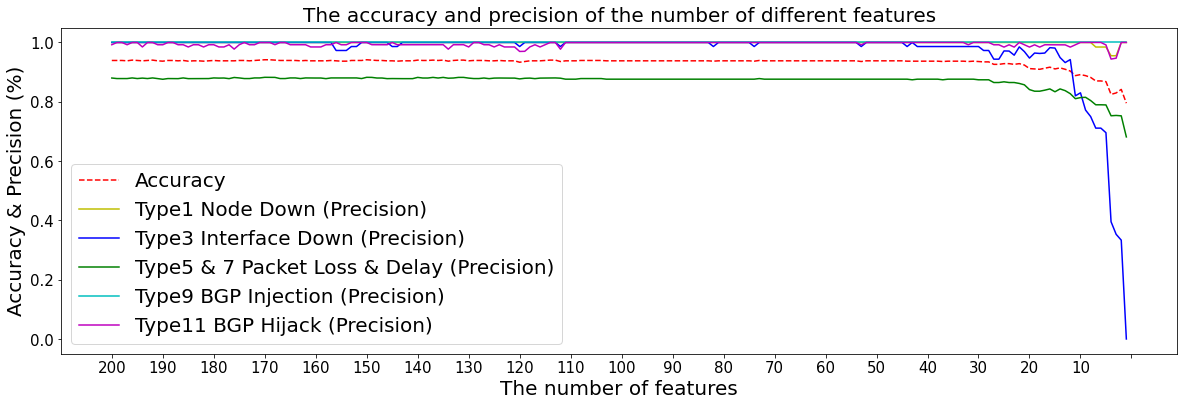

In [49]:
# X_train result
x_n = [str(200-x) for x in range(200)]
plt.figure(figsize=(20, 6))
plt.rc('font', size=15)
plt.rc('axes', labelsize=15) 
plt.plot(x_n,list_acc,'r--',label='Accuracy')
plt.plot(x_n,list_1,'y',label='Type1 Node Down (Precision)')
plt.plot(x_n,list_3,'b',label='Type3 Interface Down (Precision)')
# plt.plot(x_n,list_5,'g',label='Type5 Packet Loss')
# plt.plot(x_n,list_7,'k',label='Type7 Packet Delay')
# plt.xticks(fontsize=40)
# plt.yticks(fontsize=40)
plt.plot(x_n,list_5_7,'g',label='Type5 & 7 Packet Loss & Delay (Precision)')
plt.plot(x_n,list_9,'c',label='Type9 BGP Injection (Precision)')
plt.plot(x_n,list_11,'m',label='Type11 BGP Hijack (Precision)')
plt.legend(loc='lower left', fontsize=20)
plt.title('The accuracy and precision of the number of different features', fontsize=20)
plt.xlabel('The number of features', fontsize=20)
plt.ylabel('Accuracy & Precision (%)', fontsize=20)
plt.xticks(np.arange(200,-5,-10))
plt.show()

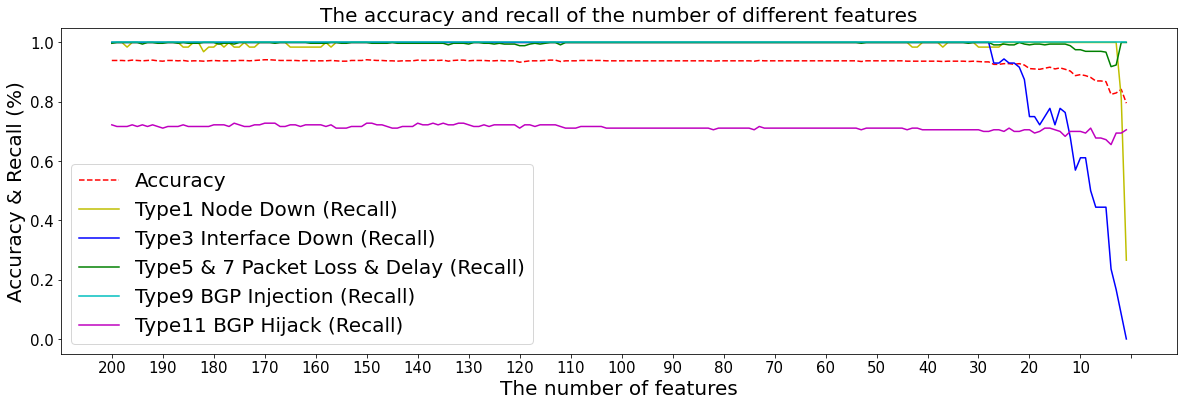

In [50]:
x_n = [str(200-x) for x in range(200)]
plt.figure(figsize=(20, 6))
plt.rc('font', size=15)
plt.rc('axes', labelsize=15) 
plt.plot(x_n,list_acc,'r--',label='Accuracy')
plt.plot(x_n,list_1_rc,'y',label='Type1 Node Down (Recall)')
plt.plot(x_n,list_3_rc,'b',label='Type3 Interface Down (Recall)')
plt.plot(x_n,list_5_7_rc,'g',label='Type5 & 7 Packet Loss & Delay (Recall)')
plt.plot(x_n,list_9_rc,'c',label='Type9 BGP Injection (Recall)')
plt.plot(x_n,list_11_rc,'m',label='Type11 BGP Hijack (Recall)')
plt.legend(loc='lower left', fontsize=20)
plt.title('The accuracy and recall of the number of different features', fontsize=20)
plt.xlabel('The number of features', fontsize=20)
plt.ylabel('Accuracy & Recall (%)', fontsize=20)
plt.xticks(np.arange(200,-5,-10))
plt.show()

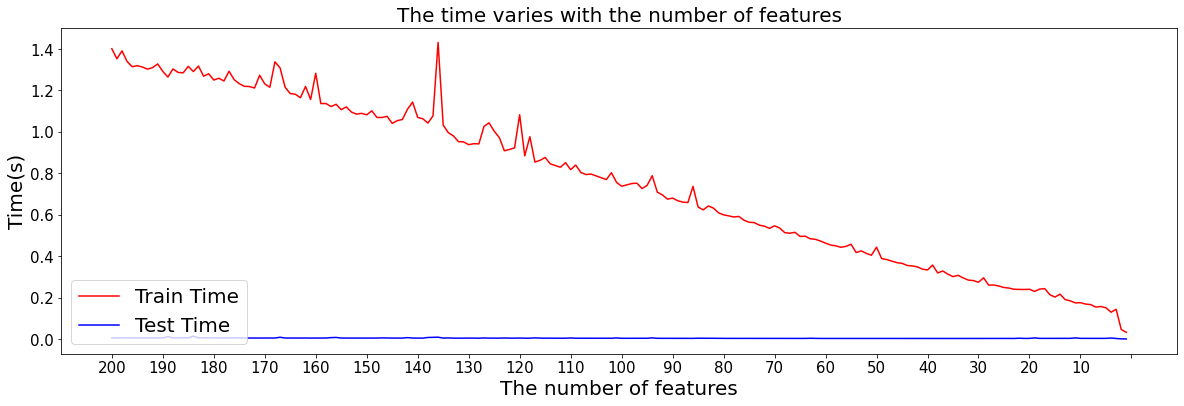

In [51]:
# time result
x_n = [str(200-x) for x in range(200)]
plt.figure(figsize=(20, 6))
plt.rc('font', size=15)
plt.rc('axes', labelsize=15) 
plt.plot(x_n,list_train_time,'r',label='Train Time')
plt.plot(x_n,list_test_time,'b',label='Test Time')
plt.legend(loc='lower left', fontsize=20)
plt.title('The time varies with the number of features', fontsize=20)
plt.xlabel('The number of features', fontsize=20)
plt.ylabel('Time(s)', fontsize=20)
plt.xticks(np.arange(200,-5,-10))
plt.show()

In [23]:
selection = SelectFromModel(model, threshold=0.0035, prefit=True)
select_X_train = selection.transform(X_train)
select_X_test = selection.transform(X_test)

In [24]:
def xgboost_show_cm(X_train, y_train, X_test, y_test):
    last_time = time.time()
    xgb = XGBClassifier(num_class=5, random_state=0)
    xgb.fit(X_train, y_train)
    middle_time = time.time()

    y_pred = xgb.predict(X_test)

    current_time = time.time()

    print("XGBOOST Accuracy: %.2f" % accuracy_score(y_test, y_pred))
    print("train time： {}".format(middle_time - last_time))
    print("test time： {}".format(current_time - middle_time))
    cm = confusion_matrix(y_test, y_pred)
    print('confusion matrix xgb:')
    print(cm)
    print('classification report xgb:')
    print(classification_report(y_test, y_pred))

In [25]:
xgboost_show_cm(X_train, y_train, X_test, y_test)

XGBOOST Accuracy: 0.93
train time： 5.633549928665161
test time： 0.038285017013549805
confusion matrix xgb:
[[ 62   0   0   2   0]
 [  0  72   0   0   0]
 [  0   0 156   0   0]
 [  0   1   0 129  50]
 [  0   0   0   2 366]]
classification report xgb:
              precision    recall  f1-score   support

           1       1.00      0.97      0.98        64
           3       0.99      1.00      0.99        72
           9       1.00      1.00      1.00       156
          11       0.97      0.72      0.82       180
          57       0.88      0.99      0.93       368

    accuracy                           0.93       840
   macro avg       0.97      0.94      0.95       840
weighted avg       0.94      0.93      0.93       840



In [26]:
xgboost_show_cm(select_X_train, y_train, select_X_test, y_test)

XGBOOST Accuracy: 0.94
train time： 0.3332650661468506
test time： 0.0037908554077148438
confusion matrix xgb:
[[ 64   0   0   0   0]
 [  0  72   0   0   0]
 [  0   0 156   0   0]
 [  0   1   0 127  52]
 [  0   0   0   0 368]]
classification report xgb:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        64
           3       0.99      1.00      0.99        72
           9       1.00      1.00      1.00       156
          11       1.00      0.71      0.83       180
          57       0.88      1.00      0.93       368

    accuracy                           0.94       840
   macro avg       0.97      0.94      0.95       840
weighted avg       0.94      0.94      0.93       840



In [27]:
print(list_acc[143])
print(list_1[143])
print(list_3[143])
print(list_5_7[143])
print(list_9[143])
print(list_11[143])

0.9380952380952381
1.0
1.0
0.8761904761904762
1.0
1.0


In [ ]:
from sklearn.decomposition import PCA

In [43]:
pca=PCA(n_components=30)     #加载PCA算法，设置降维后主成分数目为自动
reduced_X=pca.fit_transform(X)#对样本进行降维


In [44]:
# random forest
def random_forest(X_train, y_train, X_test, y_test, show=False):
    last_time = time.time()
    rf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)

    rf.fit(X_train, y_train)
    middle_time = time.time()

    y_pred = rf.predict(X_test)

    current_time = time.time()

    print("Accuracy: %.2f"% accuracy_score(y_test, y_pred))

    print("训练耗时： {}".format(middle_time - last_time))
    print("测试耗时： {}".format(current_time - middle_time))
    if show:
        cm = confusion_matrix(y_test, y_pred)
        print('confusion matrix rf:')
        print(cm)
        print('classification report rf:')
        print(classification_report(y_test, y_pred))

        plot_confusion_matrix(cm, classes=['1', '3', '9', '11'],
                              normalize=True, title='Normalized confusion matrix')

        plt.show()

Accuracy: 0.79
训练耗时： 0.16594672203063965
测试耗时： 0.012247085571289062
confusion matrix rf:
[[ 63   0   0   2]
 [  8  78  35   0]
 [  1  18 158   2]
 [  1   4  40 110]]
classification report rf:
              precision    recall  f1-score   support

           1       0.86      0.97      0.91        65
           3       0.78      0.64      0.71       121
           9       0.68      0.88      0.77       179
          11       0.96      0.71      0.82       155

    accuracy                           0.79       520
   macro avg       0.82      0.80      0.80       520
weighted avg       0.81      0.79      0.79       520

Normalized confusion matrix
[[0.96923077 0.         0.         0.03076923]
 [0.0661157  0.6446281  0.2892562  0.        ]
 [0.00558659 0.10055866 0.88268156 0.01117318]
 [0.00645161 0.02580645 0.25806452 0.70967742]]


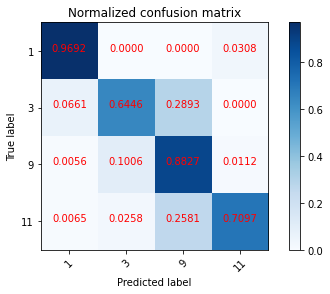

In [45]:
reduced_X_train, reduced_X_test, reduced_y_train, reduced_y_test = train_test_split(reduced_X, Y, test_size=0.7)
random_forest(reduced_X_train, reduced_y_train, reduced_X_test, reduced_y_test, show=True)

In [28]:
from lightgbm import LGBMClassifier

def gbm_show_cm(X_train, y_train, X_test, y_test):
    last_time = time.time()
    
    gbm = LGBMClassifier(learning_rate=0.1, n_estimators=40)
    gbm.fit(X_train, y_train)

    middle_time = time.time()

    y_pred = gbm.predict(X_test)

    current_time = time.time()

    print("GBM Accuracy: %.2f" % accuracy_score(y_test, y_pred))
    print("train time： {}".format(middle_time - last_time))
    print("test time： {}".format(current_time - middle_time))
    cm = confusion_matrix(y_test, y_pred)
    print('confusion matrix gbm:')
    print(cm)
    print('classification report gbm:')
    print(classification_report(y_test, y_pred))
    # 特征重要度
    print('Feature importances:', list(gbm.feature_importances_))
    
    # 网格搜索，参数优化 learning_rate=0.1, n_estimators=40
#     estimator = LGBMClassifier(num_leaves=31)
#     param_grid = {
#         'learning_rate': [0.01, 0.1, 1],
#         'n_estimators': [20, 40]
#     }
#     gbm = GridSearchCV(estimator, param_grid)
#     gbm.fit(X_train, y_train)
#     print('Best parameters found by grid search are:', gbm.best_params_)
    


In [29]:
import re
X_train_gbm = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))
X_test_gbm = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))

gbm_show_cm(X_train_gbm, y_train, X_test_gbm, y_test)

GBM Accuracy: 0.93
train time： 2.81748628616333
test time： 0.17267608642578125
confusion matrix gbm:
[[ 64   0   0   0   0]
 [  0  70   0   0   2]
 [  0   0 156   0   0]
 [  0   1   0 126  53]
 [  0   0   0   0 368]]
classification report gbm:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        64
           3       0.99      0.97      0.98        72
           9       1.00      1.00      1.00       156
          11       1.00      0.70      0.82       180
          57       0.87      1.00      0.93       368

    accuracy                           0.93       840
   macro avg       0.97      0.93      0.95       840
weighted avg       0.94      0.93      0.93       840

Feature importances: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 27, 35, 0, 3, 0, 20, 6, 31, 10, 2, 19, 6, 5, 0, 0, 10, 15, 0, 0, 0, 26, 11, 39, 33, 0, 4, 0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 